### Monte Carlo Simulation

## Load the Libs we need

In [1]:
# Import Libraries
import pandas as pd
import datetime as dt
import pytz
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
# Import specific modules
from datetime import datetime, timezone, date
from dateutil.parser import parse
from scipy.stats import t as student_t
from sklearn.linear_model import LinearRegression

## A simple Pi Example

In [2]:
def mb_estimate_pi(n):
    """
    Estimates the value of π (pi) using the Monte Carlo method.

    This function simulates the random throwing of points within a unit square and counts
    how many fall inside a quarter-circle inscribed within the square. The ratio of points
    inside the circle to the total number of points is used to estimate π.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    n (int): The number of random points to simulate.

    Returns:
    float: An estimate of the value of π.

    The Monte Carlo method for estimating π is based on the area of a quarter-circle with 
    radius 1 inside a unit square. The area of the circle is πr² (where r=1), and thus, 
    the quarter-circle's area is π/4. By randomly placing points in the square and counting 
    the fraction that falls inside the quarter-circle, we can approximate π.

    Example:
    >>> mb_estimate_pi(10000000)
    """
    start_time = time.time()  # Start the timer to measure execution time

    # Initialize counters for points inside the quarter-circle and total points
    points_inside_circle = 0
    total_points = 0

    # Generate n random points
    for _ in range(n):
        # Randomly generate x and y coordinates between 0 and 1
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)

        # Calculate the distance from the origin (0, 0) to the point (x, y)
        distance = math.sqrt(x**2 + y**2)

        # Check if the point is inside the quarter-circle (distance <= 1)
        if distance <= 1:
            points_inside_circle += 1  # Increment if inside the quarter-circle
        total_points += 1  # Increment the total points counter

    # Estimate π as 4 times the ratio of points inside the circle to the total points
    pi_estimate = 4 * points_inside_circle / total_points

    end_time = time.time()  # End the timer
    execution_time = end_time - start_time  # Calculate execution time

    # Print the time it took to run the function
    print(f"The function took {execution_time:.3f} seconds to run.")

    return pi_estimate  # Return the estimated value of π

# Estimate π with 10 million points
print(f"pi = {mb_estimate_pi(10000000)}")

The function took 11.279 seconds to run.
pi = 3.1424264


## Pricing a European Option with MCS

### Pricing a European Option using normal distribution with MCS

In [3]:
def mb_monte_carlo_european_option_pricing(S0=100, K=105, T=1.0, r=0.05, sigma=0.2, M=1000, I=50000):
    """
    Estimates the price of European call and put options using the Monte Carlo simulation method.

    This function simulates the price paths of the underlying asset using Geometric Brownian Motion (GBM),
    calculates the payoff of the options at maturity, and discounts them to present value to estimate the
    option prices.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price of the option.
    T (float): Time-to-maturity in years.
    r (float): Risk-free rate, assumed to be constant.
    sigma (float): Volatility of the underlying asset, assumed to be constant.
    M (int): Number of time steps in each simulation path.
    I (int): Number of simulation paths.

    Returns:
    C0 (float): Estimated European Call Option Value.
    P0 (float): Estimated European Put Option Value.

    The Monte Carlo method estimates the value of European options by simulating numerous random paths of the
    asset price, calculating the payoffs of the call and put options at maturity, and then averaging the discounted
    payoffs to determine the expected present value.

    Example:
    >>> mb_monte_carlo_european_option_pricing()
    """
    start_time = time.time()  # Start the timer to measure execution time
    
    # Simulating I paths with M time steps
    np.random.seed(1000)  # Set the seed for reproducibility
    dt = T / M  # Time increment per step
    S = np.zeros((M + 1, I))  # Matrix to store simulated paths
    S[0] = S0  # Initial stock price for all simulations

    # Generate asset price paths using Geometric Brownian Motion
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)  # Generate random normal variables
        # Update the asset price using the GBM formula
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate the Monte Carlo estimator for a European call option
    C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
    # Calculate the Monte Carlo estimator for a European put option
    P0 = np.exp(-r * T) * np.sum(np.maximum(K - S[-1], 0)) / I

    end_time = time.time()  # End the timer
    print(f"Execution time: {end_time - start_time:.2f} seconds")  # Display execution time
    
    return C0, P0  # Return the estimated option values

# Call the function and print the results
C0, P0 = mb_monte_carlo_european_option_pricing()
print("European Call Option Value %5.3f" % C0)
print("European Put Option Value %5.3f" % P0)

Execution time: 2.07 seconds
European Call Option Value 7.973
European Put Option Value 7.898


### Pricing a European Option using t-distribution with MCS

In [4]:
def mb_monte_carlo_european_option_pricing_t_distribution(S0=100, K=105, T=1.0, r=0.05, sigma=0.2, M=1000, I=50000, df=5):
    """
    Estimates the price of European call and put options using the Monte Carlo simulation method with
    random sampling from the Student's t-distribution.

    This function simulates the price paths of the underlying asset using a modified Geometric Brownian Motion (GBM)
    where the randomness is driven by the Student's t-distribution, which allows for heavier tails than the normal 
    distribution. This approach models the potential for larger jumps in asset prices, capturing more extreme market
    behavior.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price of the option.
    T (float): Time-to-maturity in years.
    r (float): Risk-free rate, assumed to be constant.
    sigma (float): Volatility of the underlying asset, assumed to be constant.
    M (int): Number of time steps in each simulation path.
    I (int): Number of simulation paths.
    df (int): Degrees of freedom for the Student's t-distribution, controlling the heaviness of the tails.

    Returns:
    C0 (float): Estimated European Call Option Value.
    P0 (float): Estimated European Put Option Value.

    This method adjusts the random shocks in the simulation to reflect the Student's t-distribution, capturing
    the potential for higher kurtosis and more extreme movements in asset prices compared to the normal distribution.

    Example:
    >>> mb_monte_carlo_european_option_pricing_t_distribution()
    """
    start_time = time.time()  # Start the timer to measure execution time

    # Simulating I paths with M time steps
    np.random.seed(1000)  # Set the seed for reproducibility
    dt = T / M  # Time increment per step
    df_adjustment = np.sqrt((df - 2) / df)  # Adjustment factor to standardize variance of t-distribution
    S = np.zeros((M + 1, I))  # Matrix to store simulated paths
    S[0] = S0  # Initial stock price for all simulations

    # Generate asset price paths using modified GBM with Student's t-distribution
    for t in range(1, M + 1):
        # Generate random numbers from the Student's t-distribution with specified degrees of freedom
        z = student_t.rvs(df, size=I) * df_adjustment
        # Update the asset price using the adjusted GBM formula
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate the Monte Carlo estimator for a European call option
    C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
    # Calculate the Monte Carlo estimator for a European put option
    P0 = np.exp(-r * T) * np.sum(np.maximum(K - S[-1], 0)) / I

    end_time = time.time()  # End the timer
    print(f"Execution time: {end_time - start_time:.2f} seconds")  # Display execution time
    
    return C0, P0  # Return the estimated option values

# Call the function and print the results
C0, P0 = mb_monte_carlo_european_option_pricing_t_distribution()
print("European Call Option Value %5.3f" % C0)
print("European Put Option Value %5.3f" % P0)

Execution time: 5.59 seconds
European Call Option Value 8.017
European Put Option Value 7.937


### Monte Carlo Simulation of Stock Price Paths

Execution time: 2.18 seconds


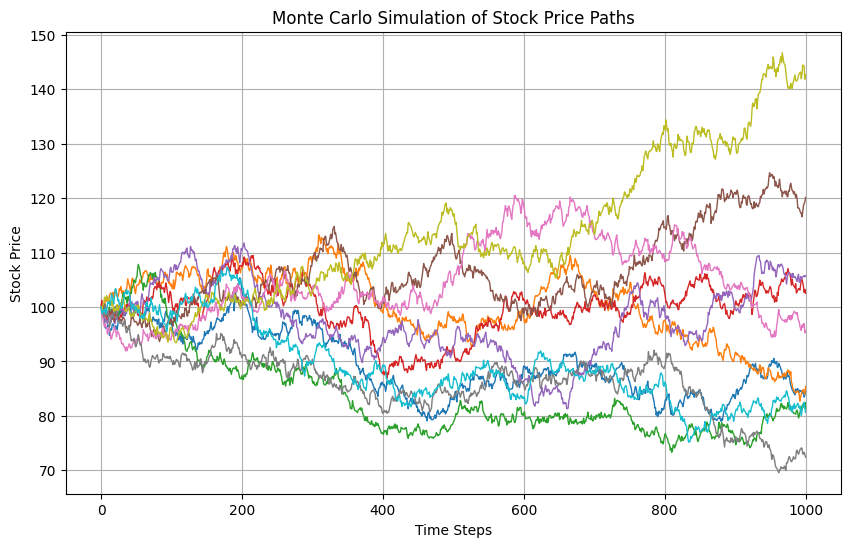

European Call Option Value 8.110
European Put Option Value 7.809


In [5]:
def mb_monte_carlo_european_option_pricing2(S0=100, K=105, T=1.0, r=0.05, sigma=0.2, M=1000, I=50000, seed=500):
    """
    Estimates the price of European call and put options using the Monte Carlo simulation method.

    This function simulates the price paths of the underlying asset using Geometric Brownian Motion (GBM),
    calculates the payoff of the options at maturity, and discounts them to present value to estimate the
    option prices. Additionally, it visualizes the first few simulated paths to provide an intuitive view
    of the random nature of the price movements.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price of the option.
    T (float): Time-to-maturity in years.
    r (float): Risk-free rate, assumed to be constant.
    sigma (float): Volatility of the underlying asset, assumed to be constant.
    M (int): Number of time steps in each simulation path.
    I (int): Number of simulation paths.
    seed (int): Seed for the random number generator to ensure reproducibility.

    Returns:
    C0 (float): Estimated European Call Option Value.
    P0 (float): Estimated European Put Option Value.

    The Monte Carlo method estimates the value of European options by simulating numerous random paths of the
    asset price, calculating the payoffs of the call and put options at maturity, and then averaging the discounted
    payoffs to determine the expected present value. This implementation also plots a few sample paths to illustrate
    the simulated price evolution.

    Example:
    >>> mb_monte_carlo_european_option_pricing2()
    """
    start_time = time.time()  # Start the timer to measure execution time
    
    # Setting the seed for reproducibility
    np.random.seed(seed)
    
    # Simulating I paths with M time steps
    dt = T / M  # Time increment per step
    S = np.zeros((M + 1, I))  # Matrix to store simulated paths
    S[0] = S0  # Initial stock price for all simulations

    # Generate asset price paths using Geometric Brownian Motion
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)  # Generate random normal variables
        # Update the asset price using the GBM formula
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate the Monte Carlo estimator for a European call option
    C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
    # Calculate the Monte Carlo estimator for a European put option
    P0 = np.exp(-r * T) * np.sum(np.maximum(K - S[-1], 0)) / I

    end_time = time.time()  # End the timer
    print(f"Execution time: {end_time - start_time:.2f} seconds")  # Display execution time
    
    # Plotting the first 10 paths to visualize the simulated price evolution
    plt.figure(figsize=(10, 6))
    for i in range(10):
        plt.plot(S[:, i], lw=1)  # Plot each of the first 10 simulated paths
    plt.title('Monte Carlo Simulation of Stock Price Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.savefig("monte_carlo_stock_paths.png")  # Save the plot to a file
    plt.show()
    
    return C0, P0  # Return the estimated option values

# Call the function and print the results
C0, P0 = mb_monte_carlo_european_option_pricing2()
print("European Call Option Value %5.3f" % C0)
print("European Put Option Value %5.3f" % P0)

## Pricing an American Option with MCS

### Pricing an American Option using t-distribution with MCS

In [6]:
def mb_monte_carlo_american_option_pricing_t_distribution(S0=100, K=105, T=1.0, r=0.05, sigma=0.2, M=1000, I=50000, df=5):
    """
    Estimates the price of American call and put options using the Monte Carlo simulation method with
    random sampling from the Student's t-distribution and Least Squares Monte Carlo (LSM) approach.

    This function simulates the price paths of the underlying asset using a modified Geometric Brownian Motion (GBM)
    where the randomness is driven by the Student's t-distribution. It employs the Least Squares Monte Carlo (LSM)
    technique to estimate the continuation value of the options at each time step, which helps in deciding whether 
    to exercise the option early, as is allowed for American-style options.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price of the option.
    T (float): Time-to-maturity in years.
    r (float): Risk-free rate, assumed to be constant.
    sigma (float): Volatility of the underlying asset, assumed to be constant.
    M (int): Number of time steps in each simulation path.
    I (int): Number of simulation paths.
    df (int): Degrees of freedom for the Student's t-distribution, controlling the heaviness of the tails.

    Returns:
    C0 (float): Estimated American Call Option Value.
    P0 (float): Estimated American Put Option Value.

    The method combines Monte Carlo simulation with LSM to estimate American option prices, accounting for the option
    holder's right to exercise at any time before expiration. The Student's t-distribution introduces heavier tails,
    capturing the potential for more extreme movements in asset prices compared to normal distributions.

    Example:
    >>> mb_monte_carlo_american_option_pricing_t_distribution()
    """
    start_time = time.time()  # Start the timer to measure execution time

    # Simulating I paths with M time steps
    np.random.seed(1000)  # Set the seed for reproducibility
    dt = T / M  # Time increment per step
    df_adjustment = np.sqrt((df - 2) / df)  # Adjustment factor to standardize variance of t-distribution
    S = np.zeros((M + 1, I))  # Matrix to store simulated paths
    S[0] = S0  # Initial stock price for all simulations

    # Generate asset price paths using modified GBM with Student's t-distribution
    for step in range(1, M + 1):
        # Generate random numbers from the Student's t-distribution with specified degrees of freedom
        z = student_t.rvs(df, size=I) * df_adjustment
        # Update the asset price using the adjusted GBM formula
        S[step] = S[step - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    # Discount factor for cash flows
    discount_factor = np.exp(-r * dt)
    
    # Initialize cash flows for put and call options
    put_cash_flows = np.maximum(K - S, 0)
    call_cash_flows = np.maximum(S - K, 0)

    # Backward induction to estimate continuation values and determine exercise strategy
    for step in range(M - 1, 0, -1):
        reg = LinearRegression()  # Linear regression model used for LSM
        
        # For put option
        in_the_money_put = put_cash_flows[step] > 0  # Identify in-the-money scenarios
        X_put = S[step, in_the_money_put]  # Stock prices where the put option is in-the-money
        Y_put = put_cash_flows[step + 1, in_the_money_put] * discount_factor  # Discounted future payoffs
        reg.fit(X_put.reshape(-1, 1), Y_put)  # Fit the regression model
        continuation_put = reg.predict(X_put.reshape(-1, 1))  # Predict the continuation value
        # Update cash flows based on the comparison between immediate exercise and continuation
        put_cash_flows[step, in_the_money_put] = np.where(
            put_cash_flows[step, in_the_money_put] > continuation_put,
            put_cash_flows[step, in_the_money_put], 0)
        put_cash_flows[step + 1] *= discount_factor  # Discount cash flows to present value

        # For call option
        in_the_money_call = call_cash_flows[step] > 0  # Identify in-the-money scenarios
        X_call = S[step, in_the_money_call]  # Stock prices where the call option is in-the-money
        Y_call = call_cash_flows[step + 1, in_the_money_call] * discount_factor  # Discounted future payoffs
        reg.fit(X_call.reshape(-1, 1), Y_call)  # Fit the regression model
        continuation_call = reg.predict(X_call.reshape(-1, 1))  # Predict the continuation value
        # Update cash flows based on the comparison between immediate exercise and continuation
        call_cash_flows[step, in_the_money_call] = np.where(
            call_cash_flows[step, in_the_money_call] > continuation_call,
            call_cash_flows[step, in_the_money_call], 0)
        call_cash_flows[step + 1] *= discount_factor  # Discount cash flows to present value

    # Calculating the option prices as the mean of discounted cash flows
    P0 = np.mean(put_cash_flows[1] * discount_factor)
    C0 = np.mean(call_cash_flows[1] * discount_factor)

    end_time = time.time()  # End the timer
    print(f"Execution time: {end_time - start_time:.2f} seconds")  # Display execution time

    return C0, P0  # Return the estimated option values

# Call the function and print the results
C0, P0 = mb_monte_carlo_american_option_pricing_t_distribution()
print("American Call Option Value %5.3f" % C0)
print("American Put Option Value %5.3f" % P0)

Execution time: 15.97 seconds
American Call Option Value 0.000
American Put Option Value 4.320


## Monte Carlo Pricing of a Down-and-Out Call Option

In [7]:
def monte_carlo_barrier_option(S0=100, K=105, T=1.0, r=0.05, sigma=0.2, B=90, M=1000, I=50000):
    """
    Monte Carlo simulation for pricing a Down-and-Out Call Option using Geometric Brownian Motion (GBM).

    This function simulates the price paths of the underlying asset with a specified barrier level that, if breached,
    knocks the option out, meaning it becomes worthless. The Down-and-Out Call Option is a type of barrier option 
    that only has value if the asset price remains above the barrier level throughout the option's life.
    Furthermore, the function prints a string showing its execution time.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price of the option.
    T (float): Time-to-maturity in years.
    r (float): Risk-free rate, assumed to be constant.
    sigma (float): Volatility of the underlying asset, assumed to be constant.
    B (float): Barrier level (down-and-out); the option is knocked out if the price falls below this level.
    M (int): Number of time steps in each simulation path.
    I (int): Number of simulation paths.

    Returns:
    C0 (float): Estimated Down-and-Out Call Option Value.

    The Monte Carlo method generates random paths of the asset price and checks whether each path breaches the
    barrier level. If breached, the option's payoff is set to zero for that path. Otherwise, the payoff is calculated
    as a standard European call option payoff at maturity.

    Example:
    >>> monte_carlo_barrier_option()
    """
    start_time = time.time()  # Start the timer to measure execution time
    
    # Time increment per step
    dt = T / M
    # Discount factor to bring payoffs to present value
    discount_factor = np.exp(-r * T)
    
    # Simulating the price paths
    np.random.seed(42)  # For reproducibility of results
    S = np.zeros((M + 1, I))  # Matrix to store simulated paths
    S[0] = S0  # Set initial price for all simulations
    barrier_breached = np.zeros(I, dtype=bool)  # Array to track if the barrier is breached

    # Generate asset price paths using Geometric Brownian Motion
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)  # Generate random standard normal variables
        # Update the asset price using the GBM formula
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
        # Check if the barrier has been breached at any point along the path
        barrier_breached = barrier_breached | (S[t] <= B)

    # Payoff calculation (only for paths that do not breach the barrier)
    payoffs = np.maximum(S[-1] - K, 0)  # Standard call option payoff at maturity
    payoffs[barrier_breached] = 0  # Set payoff to zero if the barrier was breached

    # Estimate the option value as the mean of discounted payoffs
    C0 = discount_factor * np.mean(payoffs)
    
    end_time = time.time()  # End the timer
    print(f"Execution time: {end_time - start_time:.2f} seconds")  # Display execution time
    
    return C0

# Call the function and print the result
C0 = monte_carlo_barrier_option()
print("Down-and-Out Call Option Value: %5.3f" % C0)

Execution time: 4.52 seconds
Down-and-Out Call Option Value: 6.886
